In [1]:
# Copyright 2019 The Authors. All Rights Reserved.
#
# GNU General Public License v3.0
# Permissions of this strongest copyleft license are conditioned on 
# making available complete source code of licensed works and modifications, 
# which include larger works using a licensed work, under the same license. 
# Copyright and license notices must be preserved. 
# Contributors provide an express grant of patent rights. 
# When a modified version is used to provide a service over a network, 
# the complete source code of the modified version must be made available.
# ==============================================================================

# Title: Clustering of CRISPR repeats using Autoencoders
# Author: Hyunjin Shim
# Date created: 20200207
# Email: jinenstar@gmail.com

# Clustering CRISPR repeats using Autoencoders

- to analyze CRISPR repeats from CRISPR-Cas++
- to cluster CRISPR repeats by type
- to perform dimensionality reduction to identify patterns
- to visualize the results after each experimentation
- to assess the best possible network architecture

# Dataset description
- Total: 19,321 repeats
- Classified: some repeats classified by Type from CRISPR-Cas++ (CRISPR_repeat_data_processing.ipynb)

In [2]:
# Data
import os
from pathlib import Path 
import glob
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple

# Biopython
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord

# Regular expression
import re

# Plot
from pylab import *
import pylab as pylab
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.patches as mpatches

# Tensorflow
import tensorflow as tf
from keras.layers import Input, Dense, Masking
from keras.models import Model
from keras.optimizers import Adam, SGD
from tensorflow.keras import layers

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
import itertools

# Math
import math
from statistics import mean, stdev


Using TensorFlow backend.


# Step 1: Load and preprocess raw data

In [3]:
# location of raw data file
datapath = Path("/Users/jinenstar/Desktop/Data/CRISPR/CRISPR-Cas++/Repeat/Data_DR")
#os.chdir(datapath)

nt_vocab = {"<pad>":0, "T":1, "A":2, "G":3, "C":4, "t":1, "a":2, "g":3, "c":4, "N":0, "n":0, "K":0, "k":0, "Y":0, "y":0, "M":0, "m":0, "R":0, "r":0, "W":0, "w":0, "S":0, "s":0, "H":0, "h":0, "B":0, "b":0, "D":0, "d":0, ".":"", "(":"", ")":""}

def extract_dataset_info(records: List[SeqRecord]) -> Dict: 
    # Contains information on dataset
    seqs_id = [r.id for r in records]
    seqs_len = [len(r.seq) for r in records]
    seqs = [str(r.seq) for r in records]
    int_seqs = [[nt_vocab[nt] for nt in s] for s in seqs]
    d = {"ID":seqs_id, "Seq":seqs, "Int_Seq":int_seqs, "Length":seqs_len}
    return d

def calculate_GC_content(Seq): 
    GC_bySeq = [None] * len(Seq)
    for i in range(len(Seq)):
        T=0; A=0; G=0; C=0
        T = T+Seq[i].count("T")
        A = A+Seq[i].count("A")
        G = G+Seq[i].count("G")
        C = C+Seq[i].count("C")
        GC_bySeq[i] = (G+C)/(T+A)
    return mean(GC_bySeq), stdev(GC_bySeq) if len(GC_bySeq) > 1 else None

def calculate_Shannon_E(Seq):
    all_Shannon = [None]*len(Seq)
    all_Entropy = [None]*len(Seq)
    
    for i in range(len(Seq)): 
        Seq_len = len(Seq[i])
        f1 = Seq[i].count('T')/Seq_len
        f2 = Seq[i].count('A')/Seq_len
        f3 = Seq[i].count('G')/Seq_len
        f4 = Seq[i].count('C')/Seq_len
        all_Shannon[i] = -((f1*(math.log(f1,2) if f1 != 0 else 0)) + (f2*(math.log(f2,2) if f2 != 0 else 0)) + (f3*(math.log(f3,2) if f3 != 0 else 0)) + (f4*(math.log(f4,2) if f4 != 0 else 0)))
        all_Entropy[i] = all_Shannon[i]/Seq_len
    return mean(all_Entropy), stdev(all_Entropy) if len(all_Entropy) > 1 else None

def calculate_cluster_mean(cluster):
    return mean(cluster["length"])

def calculate_cluster_stdev(cluster):
    return stdev(cluster["length"])

In [4]:
repeat_data = {"train": None, "test": {}}
repeat_data_info = {"train": None, "test": {}}

# Load train sequences
train_path = datapath / Path("20190618_dr_34.fasta")
records = list(SeqIO.parse(str(train_path), "fasta"))
repeat_data_info["train"] = extract_dataset_info(records)

# Load test sequences
for f in datapath.glob("*.fa"):
  records = list(SeqIO.parse(str(f), "fasta"))
  key = f.stem
  repeat_data_info["test"][key] = extract_dataset_info(records)

In [5]:
type(repeat_data_info["test"]["TypeIA"]["Seq"])

list

In [8]:
GC_content = {}
for key in repeat_data_info["test"]:
    GC_content.update({key:calculate_GC_content(repeat_data_info["test"][key]["Seq"])})
GC_content

{'TypeIB': (0.5291674990485553, 0.41895212273428745),
 'TypeIF': (0.9866995157641993, 0.35174569763209734),
 'TypeVA': (0.35111223966771193, 0.07799483108630617),
 'orphan': (1.447655875330106, 0.963742093527931),
 'TypeIC': (1.6038312046877894, 0.650818984169512),
 'TypeIIID': (0.820328100388654, 0.5191948215920245),
 'TypeIIC': (0.4940765003412223, 0.2989005456646824),
 'TypeIIIA': (0.7924045731647185, 0.3417944564328817),
 'TypeIU': (1.4044931029189975, 0.34893634371631105),
 'TypeIIB': (0.4899211345630783, 0.12585092455684177),
 'TypeVIB1': (0.7682742287678541, 0.13927021121519312),
 'TypeIIIB': (0.814499602896012, 0.5595589564516888),
 'TypeIV': (0.8708133253301321, 0.13526370934011894),
 'Cas1': (0.8121564040292641, 0.4419096280804674),
 'TypeVIB2': (0.5161290322580645, None),
 'TypeIIA': (0.5772538602564823, 0.18195720019368286),
 'TypeIIIC': (1.5582417582417583, 0.2630657685811725),
 'TypeID': (0.6212254098737916, 0.27662605526256484),
 'TypeIA': (0.5396058703754588, 0.38012961

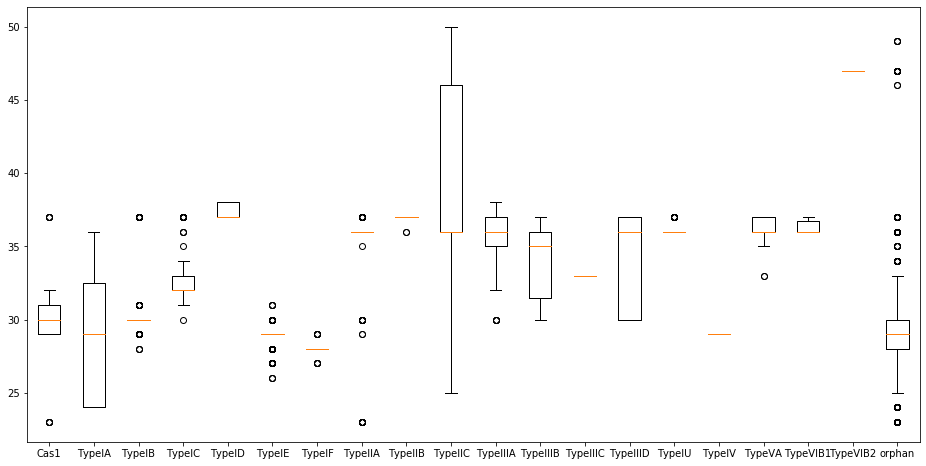

In [9]:
%matplotlib inline

# plot length for each type
labels = sorted(repeat_data_info["test"].keys())
data = []

for key in sorted(repeat_data_info["test"].keys()):
    data.append(repeat_data_info["test"][key]["Length"])

fig1, ax1 = plt.subplots(figsize=(16,8))
ax1.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()
# fig1.savefig('CRISPR_DR_PublicParis_boxplot_length.pdf')
# fig1.savefig('CRISPR_DR_PublicParis_boxplot_length.png')

In [10]:
repeat_data_info["test"]["TypeIA"].keys()

dict_keys(['ID', 'Seq', 'Int_Seq', 'Length'])

In [11]:
all_sequence_no = repeat_data_info["train"]["Int_Seq"]

In [12]:
# numpy array of sequences of a fixed length
# define dimension of features
no_dim_features = 50
# define numpy array with dimension
all_sequence_no_dim = np.empty(shape=(len(all_sequence_no),no_dim_features))

print(all_sequence_no_dim.shape)

for n in range(len(all_sequence_no)):
    # convert char sequence to digit sequence
    sequence_digits=[int(d) for d in all_sequence_no[n]]
    # store digit sequence into numpy with right dimension
    if len(sequence_digits) <= no_dim_features:
        all_sequence_no_dim[n,0:len(sequence_digits)]=sequence_digits[0:len(sequence_digits)]
    else:
        all_sequence_no_dim[n]=sequence_digits[0:no_dim_features]   

(19321, 50)


In [13]:
#scale data 0-1
min_max_scaler = MinMaxScaler( feature_range=(0,1), copy=True )
x_train = min_max_scaler.fit_transform(all_sequence_no_dim)

In [14]:
all_sequence_no_test=[]
for key in repeat_data_info["test"].keys():
    all_sequence_no_test.extend(repeat_data_info["test"][key]["Int_Seq"])
    print(key)
#print(all_sequence_no_test)

TypeIB
TypeIF
TypeVA
orphan
TypeIC
TypeIIID
TypeIIC
TypeIIIA
TypeIU
TypeIIB
TypeVIB1
TypeIIIB
TypeIV
Cas1
TypeVIB2
TypeIIA
TypeIIIC
TypeID
TypeIA
TypeIE


In [15]:
# numpy array of sequences of a fixed length
# define dimension of features
no_dim_features = 50
# define numpy array with dimension
all_sequence_no_dim_test = np.empty(shape=(len(all_sequence_no_test),no_dim_features))

print(all_sequence_no_dim_test.shape)

for n in range(len(all_sequence_no_test)):
    # convert char sequence to digit sequence
    sequence_digits=[int(d) for d in all_sequence_no_test[n]]
    # store digit sequence into numpy with right dimension
    if len(sequence_digits) <= no_dim_features:
        all_sequence_no_dim_test[n,0:len(sequence_digits)]=sequence_digits[0:len(sequence_digits)]
    else:
        all_sequence_no_dim_test[n]=sequence_digits[0:no_dim_features]   

(7952, 50)


In [16]:
all_sequence_no_dim_test

array([[3., 2., 2., ..., 0., 0., 0.],
       [3., 2., 2., ..., 0., 0., 0.],
       [3., 2., 2., ..., 0., 0., 0.],
       ...,
       [3., 3., 3., ..., 0., 0., 0.],
       [3., 3., 4., ..., 0., 0., 0.],
       [3., 4., 1., ..., 0., 0., 0.]])

In [17]:
#scale data 0-1
min_max_scaler = MinMaxScaler( feature_range=(0,1), copy=True )
x_test = min_max_scaler.fit_transform(all_sequence_no_dim_test)

# Step 2: Autoencoder model
- use Keras to create, compile, fit autoencoder model

In [18]:
# Setseed
def reproduce(seed_number):
    import random
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(seed_number)
    random.seed(seed_number)
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    tf.set_random_seed(seed_number)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    tf.keras.backend.set_session(sess)
reproduce(2020)

#plot original data, reconstructed data, residuals
def plot_reconstruction(data_norm, data_dec):
    fig = plt.figure(figsize=(30,20))
    plt.subplot(3,1,1)
    cmap = cm.get_cmap('PuRd', 5)
    
    ax1 = plt.imshow(data_norm, cmap=cmap, aspect="auto", vmin=0, vmax=1)
    plt.tick_params(labelsize=20)
    cbar = plt.colorbar(ticks=[0,0.25,0.5,0.75,1])
    cbar.ax.set_yticklabels(['0:NA', '0.25:T', '0.5:A', '0.75:G', '1:C'])
    cbar.ax.tick_params(labelsize=20)
    plt.title('Original data', fontsize=25)
    plt.subplot(3,1,2)
    
    ax2 = plt.imshow(data_dec, cmap=cmap, aspect="auto", vmin=0, vmax=1)
    plt.tick_params(labelsize=20)
    cbar = plt.colorbar(ticks=[0,0.25,0.5,0.75,1])
    cbar.ax.set_yticklabels(['0:NA', '0.25:T', '0.5:A', '0.75:G', '1:C'])
    cbar.ax.tick_params(labelsize=20)
    plt.title('Reconstructed data', fontsize=25)
    plt.subplot(3,1,3)
    
    ax3 = plt.imshow(data_norm-data_dec, cmap="seismic", aspect="auto", vmin=-1, vmax=1)
    plt.tick_params(labelsize=20)
    cbar = plt.colorbar(ax3)
    cbar.ax.tick_params(labelsize=20)
    plt.title('Residuals', fontsize=25)

    plt.show()
#    fig.savefig('CRISPR_DR_PublicParis_Reconstructed.pdf')
#    fig.savefig('CRISPR_DR_PublicParis_Reconstructed.png')
    # print residual values
    print(sum(abs(data_norm-data_dec)))
    
#plot training history
def plot_history(autoencoder):
    fig = plt.figure(figsize=(6,4))
    plt.plot(autoencoder.history.history['loss'])
#    plt.plot(autoencoder.history.history['val_loss'])
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss function', fontsize=12)
    plt.legend(['Training set'], fontsize=12)
    plt.show()
#    fig.savefig('CRISPR_DR_PublicParis_history.pdf')
#    fig.savefig('CRISPR_DR_PublicParis_history.png')

In [19]:
#set dimensions of input and hidden layer
input_dim = no_dim_features
# intermediate_1 = int(input_dim/2)
# intermediate_2 = int(intermediate_1/2)
# intermediate_3 = int(intermediate_2/2)
latent_dim = 2

# Keras API default: weight=glorot_uniform, bias=zeros
input_data = Input(shape=(input_dim,))
#input_data_masked = Masking(mask_value=0)(input_data)

#encode the input with a dense layer
encoded_1 = Dense(latent_dim, activation='relu')(input_data)
#encoded_1 = Dense(latent_dim, activation='relu')(input_data_masked)
# encoded_2 = Dense(intermediate_2, activation='sigmoid')(encoded_1)
# encoded_3 = Dense(intermediate_3, activation='sigmoid')(encoded_2)
# encoded_4 = Dense(latent_dim, activation='sigmoid')(encoded_3)

#decode the encoded input to its reconstruction
# decoded_1 = Dense(intermediate_3, activation='sigmoid')(encoded_4)
# decoded_2 = Dense(intermediate_2, activation='sigmoid')(decoded_1)
# decoded_3 = Dense(intermediate_1, activation='sigmoid')(decoded_2)
decoded_1 = Dense(input_dim, activation='sigmoid')(encoded_1)

#autoencoder_2 maps the input to the output
autoencoder_1 = Model(input_data, decoded_1)

#encoder_2 maps the input to the latent representation
encoder_1 = Model(input_data, encoded_1)

#compile the model and set the desired optimizer and loss function
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

autoencoder_1.compile(optimizer=adam, loss='mean_squared_error')
autoencoder_1.summary()
autoencoder_1.fit(x_train, x_train,
                epochs=1000,
                batch_size=256,
                shuffle=False)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 102       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                150       
Total params: 252
Trainable params: 252
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
19321/19321 [==============================] - 0s 14us/step - loss: 0.1582
Epoch 2/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.1558
Epoch 3/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.1539
Epoch 4/1000
19321/19321 [

19321/19321 [==============================] - 0s 3us/step - loss: 0.0491
Epoch 171/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0490
Epoch 172/1000
19321/19321 [==============================] - 0s 5us/step - loss: 0.0490
Epoch 173/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0490
Epoch 174/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0490
Epoch 175/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0489
Epoch 176/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0489
Epoch 177/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0489
Epoch 178/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0489
Epoch 179/1000
19321/19321 [==============================] - 0s 4us/step - loss: 0.0488
Epoch 180/1000
19321/19321 [==============================] - 0s 4us/step - loss: 0.0488
Epoch 181/1000
19321/19321 [========

Epoch 262/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0474
Epoch 263/1000
19321/19321 [==============================] - 0s 4us/step - loss: 0.0474
Epoch 264/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0474
Epoch 265/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0473
Epoch 266/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0473
Epoch 267/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0473
Epoch 268/1000
19321/19321 [==============================] - 0s 4us/step - loss: 0.0473
Epoch 269/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0473
Epoch 270/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0473
Epoch 271/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0473
Epoch 272/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0473
Epoch 273/1000
19321/

19321/19321 [==============================] - 0s 3us/step - loss: 0.0468
Epoch 355/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0468
Epoch 356/1000
19321/19321 [==============================] - 0s 4us/step - loss: 0.0468
Epoch 357/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0468
Epoch 358/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0468
Epoch 359/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0468
Epoch 360/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0468
Epoch 361/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0468
Epoch 362/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0468
Epoch 363/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0468
Epoch 364/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0468
Epoch 365/1000
19321/19321 [========

19321/19321 [==============================] - 0s 3us/step - loss: 0.0463
Epoch 539/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0463
Epoch 540/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0463
Epoch 541/1000
19321/19321 [==============================] - 0s 2us/step - loss: 0.0463
Epoch 542/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0463
Epoch 543/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0463
Epoch 544/1000
19321/19321 [==============================] - 0s 4us/step - loss: 0.0463
Epoch 545/1000
19321/19321 [==============================] - ETA: 0s - loss: 0.046 - 0s 4us/step - loss: 0.0463
Epoch 546/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0463
Epoch 547/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0463
Epoch 548/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0463
Epoch 549/10

Epoch 630/1000
19321/19321 [==============================] - 0s 5us/step - loss: 0.0462
Epoch 631/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0462
Epoch 632/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0462
Epoch 633/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0462
Epoch 634/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0462
Epoch 635/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0462
Epoch 636/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0462
Epoch 637/1000
19321/19321 [==============================] - 0s 4us/step - loss: 0.0462
Epoch 638/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0462
Epoch 639/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0462
Epoch 640/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0462
Epoch 641/1000
19321/

19321/19321 [==============================] - 0s 3us/step - loss: 0.0462
Epoch 723/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0462
Epoch 724/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0462
Epoch 725/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0462
Epoch 726/1000
19321/19321 [==============================] - 0s 4us/step - loss: 0.0462
Epoch 727/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0462
Epoch 728/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0462
Epoch 729/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0462
Epoch 730/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0462
Epoch 731/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0462
Epoch 732/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0462
Epoch 733/1000
19321/19321 [========

19321/19321 [==============================] - 0s 3us/step - loss: 0.0461
Epoch 907/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0461
Epoch 908/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0461
Epoch 909/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0461
Epoch 910/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0461
Epoch 911/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0461
Epoch 912/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0461
Epoch 913/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0461
Epoch 914/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0461
Epoch 915/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0461
Epoch 916/1000
19321/19321 [==============================] - 0s 3us/step - loss: 0.0461
Epoch 917/1000
19321/19321 [========

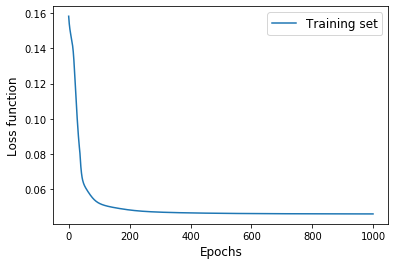

In [20]:
plot_history(autoencoder_1)

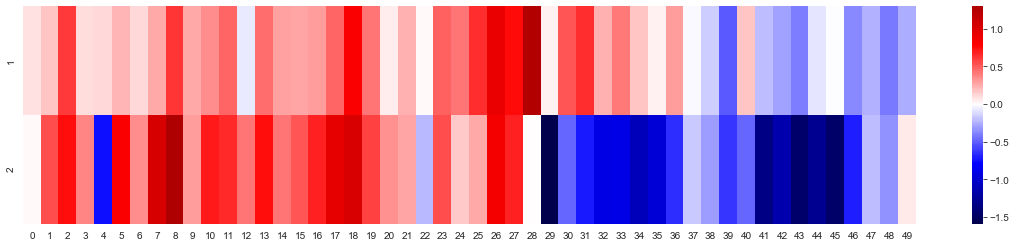

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

#get the weights of the hidden layer
weights=autoencoder_1.layers[1].get_weights()
#visualize the weights
fig = plt.figure(figsize=(20,4))
y_axis_labels = [1,2]
sns.heatmap(data=transpose(weights[0]), yticklabels=y_axis_labels, cmap='seismic', center=0)
plt.show()
# fig.savefig('CRISPR_DR_PublicParis_weights.pdf')
# fig.savefig('CRISPR_DR_PublicParis_weights.png')

In [22]:
# encoder input into latent dimensions
x_enc_1 = encoder_1.predict(x_test, batch_size=256)

In [23]:
# save results into a dataframe
labels = []
lengths = []
IDs = []
seqs = []

for key in repeat_data_info["test"].keys():
    IDs.extend(repeat_data_info["test"][key]["ID"])
    lengths.extend(repeat_data_info["test"][key]["Length"])
    seqs.extend(repeat_data_info["test"][key]["Seq"])
    labels.extend([key] * len(repeat_data_info["test"][key]["ID"]))

res_df = pd.DataFrame()
res_df["latent_1"] = x_enc_1[:, 0]
res_df["latent_2"] = x_enc_1[:, 1]
res_df["ID"] = IDs
res_df["label"] = labels
res_df["length"] = lengths
res_df["seq"] = seqs

In [24]:
res_df

,latent_1,latent_2,ID,label,length,seq
0,2.254028,4.869421,CP012098.1,TypeIB,30,GAATTAATACAAAAATAATGGAAGTCAAGA
1,1.428339,4.403649,CP012098.1,TypeIB,30,GAATTAATAGAAACATAATGGAATTTAAAG
2,1.230514,4.562381,CP012098.1,TypeIB,30,GAATTAATAGAATCATATTGGAAAATGTTA
3,0.721155,3.854463,CP012098.1,TypeIB,30,AAAATAATAGAATTTTATTGAAATTTAAAT
4,1.447638,5.675862,CP001999.1,TypeIB,30,CTTGAACCAAAACATATGATGTATTGAAAT
5,1.566391,5.913025,CP001999.1,TypeIB,30,CTTGAACCAAGACATATGATGTATTGAAAT
6,1.545065,5.799376,CP001999.1,TypeIB,30,CTTGAACCAAGACATATGATATATTGAAAT
7,2.666940,6.358883,CP025535.1,TypeIB,29,CTTTATATCCCACTACGTTCAGATAAAAC
8,2.258650,6.739451,CP025535.1,TypeIB,29,GTTTTATCTGAACGTAGTGGGATGTAAAG
9,1.411441,2.995808,AP012048.1,TypeIB,30,GTTTCAATACATTATATGTTTAAGTTCAAG


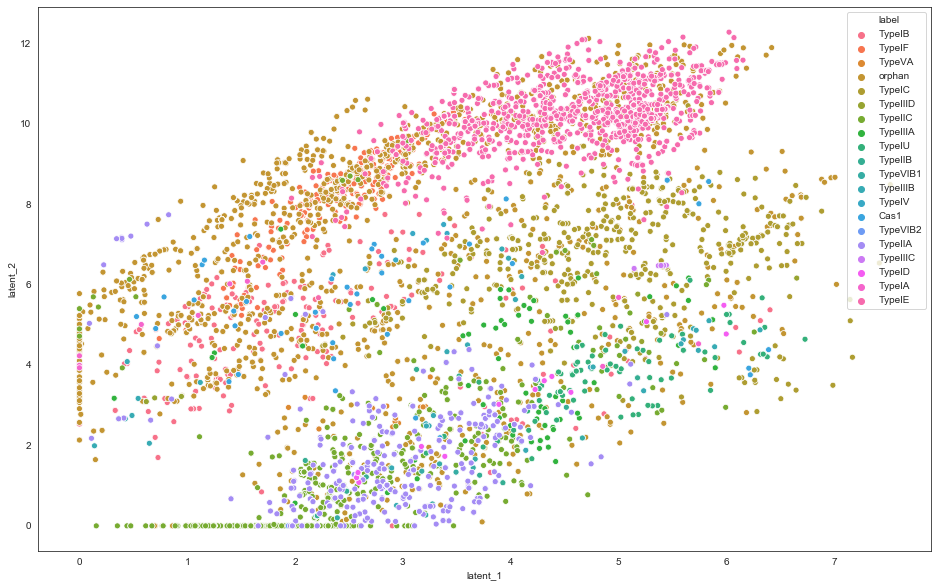

In [43]:
# plot test sequences by labels
plt.figure(figsize=(16,10))
sns.scatterplot("latent_1", "latent_2", hue="label", data=res_df)
plt.show()

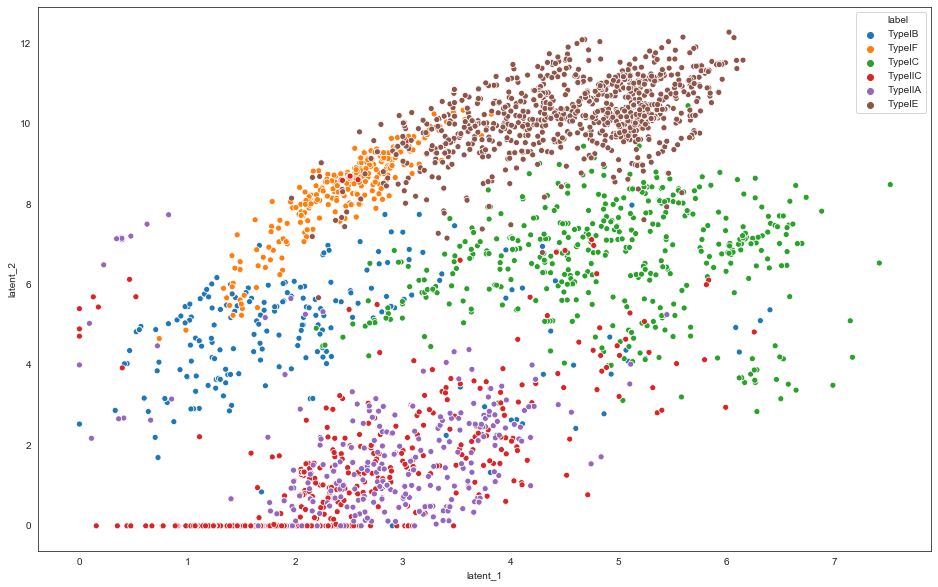

In [47]:
# plot only major test sequences by labels
Type = ['TypeIF','TypeIE','TypeIB','TypeIC','TypeIIC','TypeIIA']
df_major = res_df[res_df.label.isin(Type)]
plt.figure(figsize=(16,10))
sns.scatterplot(x = "latent_1", y = "latent_2", hue="label", data=df_major)
plt.show()

# Step 3: Clustering algorithm 
- use GMM, k-means clustering in latent dimension

In [27]:
# Gaussian Mixture Model (GMM)
lowest_bic = np.infty
bic = []
n_components_range = range(1, 10)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(x_enc_1)
        bic.append(gmm.bic(x_enc_1))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

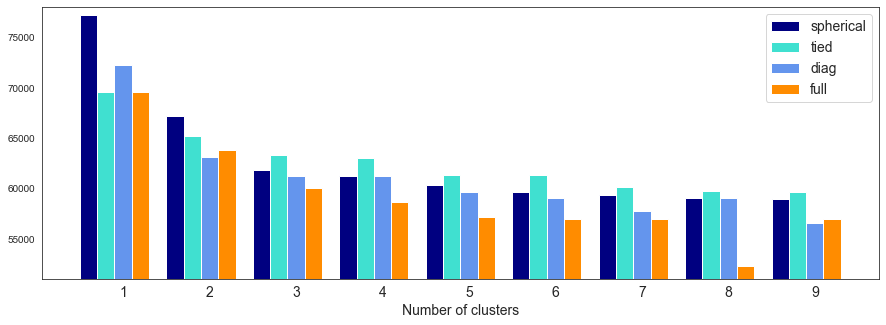

In [28]:
# Plot the BIC scores
fig = plt.figure(figsize=(15, 5))
#spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range, fontsize=14)
plt.ylim([bic.min() * 1.05 - .05 * bic.max(), bic.max() * 1.01])
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.xlabel('Number of clusters', fontsize=14)
plt.legend([b[0] for b in bars], cv_types, fontsize=14)

#fig.savefig('CRISPR_DR_PublicParis_GMM_BIC.pdf')

In [29]:
# winner as component = 7
n_clusters=7
Gmix = GaussianMixture(n_clusters, covariance_type='full', tol=0.001, reg_covar=1e-06, max_iter=100, n_init=1, init_params='kmeans', weights_init=None, means_init=None, precisions_init=None, random_state=None, warm_start=False, verbose=0, verbose_interval=10).fit_predict(x_enc_1)

In [30]:
Gmix[:100]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 5, 5, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [31]:
res_df["Gmix"] = Gmix

In [32]:
res_df

,latent_1,latent_2,ID,label,length,seq,Gmix
0,2.254028,4.869421,CP012098.1,TypeIB,30,GAATTAATACAAAAATAATGGAAGTCAAGA,3
1,1.428339,4.403649,CP012098.1,TypeIB,30,GAATTAATAGAAACATAATGGAATTTAAAG,3
2,1.230514,4.562381,CP012098.1,TypeIB,30,GAATTAATAGAATCATATTGGAAAATGTTA,3
3,0.721155,3.854463,CP012098.1,TypeIB,30,AAAATAATAGAATTTTATTGAAATTTAAAT,3
4,1.447638,5.675862,CP001999.1,TypeIB,30,CTTGAACCAAAACATATGATGTATTGAAAT,3
5,1.566391,5.913025,CP001999.1,TypeIB,30,CTTGAACCAAGACATATGATGTATTGAAAT,3
6,1.545065,5.799376,CP001999.1,TypeIB,30,CTTGAACCAAGACATATGATATATTGAAAT,3
7,2.666940,6.358883,CP025535.1,TypeIB,29,CTTTATATCCCACTACGTTCAGATAAAAC,3
8,2.258650,6.739451,CP025535.1,TypeIB,29,GTTTTATCTGAACGTAGTGGGATGTAAAG,3
9,1.411441,2.995808,AP012048.1,TypeIB,30,GTTTCAATACATTATATGTTTAAGTTCAAG,3


In [33]:
# save test sequences to .fa files by cluster
# for n in range(n_clusters):
#     cluster = res_df.loc[res_df['Gmix']==n]
#     with open('PublicCRISPR_repeats_autoencoder' + str(n) + '.fa', 'w') as f:
#         for i in range(len(cluster)):
#             f.write(">" + str(cluster["ID"].iloc[i]) + "\n" + str(cluster["label"].iloc[i]) + "\n")

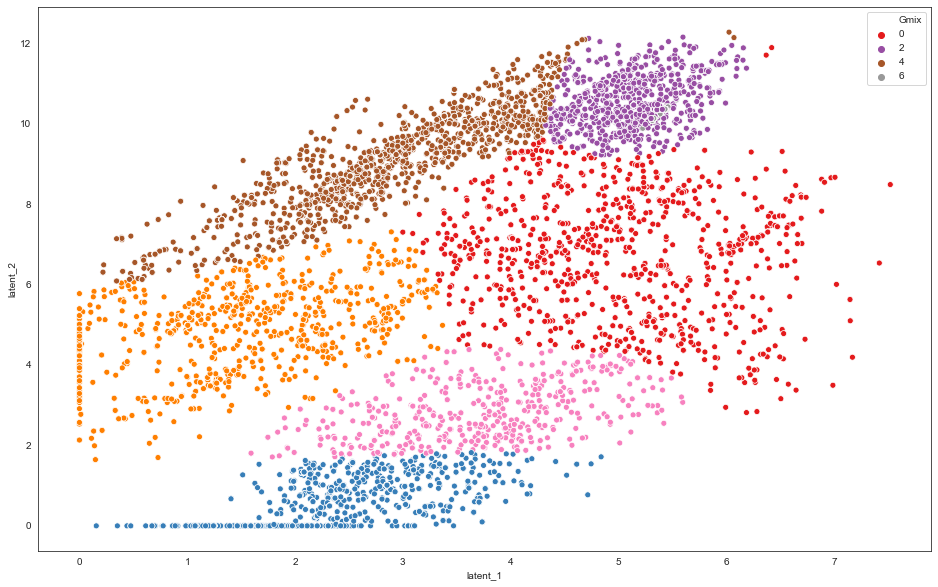

In [44]:
# plot test sequences by cluster
plt.figure(figsize=(16,10))
sns.scatterplot("latent_1", "latent_2", hue="Gmix", data=res_df, palette="Set1")
plt.show()

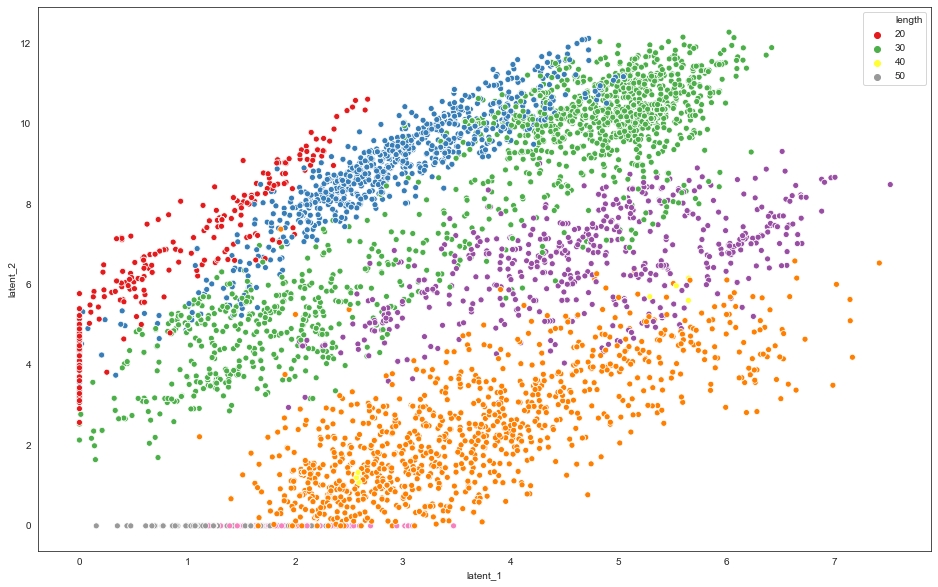

In [45]:
# plot test sequences by length
plt.figure(figsize=(16,10))
sns.scatterplot("latent_1", "latent_2", hue="length", data=res_df, palette="Set1")
plt.show()

In [36]:
#calculate mean and stdev of length by cluster
length_cluster = {}
for n in range(n_clusters):
    dat_cluster = res_df.loc[res_df['Gmix']==n]
    length_cluster.update({n:(calculate_cluster_mean(dat_cluster),calculate_cluster_stdev(dat_cluster))})
length_cluster

{0: (32.35457516339869, 2.0671701575857013),
 1: (38.2546468401487, 4.2365219132767065),
 2: (29.022126613398893, 0.2752650985651711),
 3: (29.17699115044248, 2.1642625939982074),
 4: (27.384881708020774, 1.6599277754868274),
 5: (36.06089309878214, 0.6399735455182103),
 6: (29, 0.0)}

In [37]:
#calculate GC content by cluster
GC_content_cluster = {}
for n in range(n_clusters):
    dat_cluster = res_df.loc[res_df['Gmix']==n]
    dat_cluster_seq = dat_cluster["seq"].tolist()
    GC_content_cluster.update({n:calculate_GC_content(dat_cluster_seq)})
GC_content_cluster

{0: (1.6671304754879632, 0.7013433354636283),
 1: (0.48075452802784535, 0.1901279474653703),
 2: (2.214895494282403, 0.6302535955468125),
 3: (0.4485096505964492, 0.3036077831112055),
 4: (1.5400804573941138, 0.7881678336796208),
 5: (0.6777074396801115, 0.32861591033853466),
 6: (2.121292831462323, 0.1664437115555213)}

In [38]:
#calculate Entropy by cluster
Shannon_E_cluster = {}
for n in range(n_clusters):
    dat_cluster = res_df.loc[res_df['Gmix']==n]
    dat_cluster_seq = dat_cluster["seq"].tolist()
    Shannon_E_cluster.update({n:calculate_Shannon_E(dat_cluster_seq)})
Shannon_E_cluster

{0: (0.05942518479165216, 0.004109226605502235),
 1: (0.048373077025805476, 0.005330952778293812),
 2: (0.06463521888507967, 0.002545668904520269),
 3: (0.06091140243790575, 0.006634096279736591),
 4: (0.07036556514809755, 0.005007599022825299),
 5: (0.0518312926469365, 0.002923040052590613),
 6: (0.06552954608473946, 0.000587116581627885)}